In [ ]:
#mainly based based on https://github.com/Diyago/ML-DL-scripts/tree/master/DEEP%20LEARNING/segmentation/Segmentation%20pipeline

In [ ]:
IMAGE_SIZE = (512, 512)
NUMBER_OF_FOLDS = 5
NUMBER_OF_EPOCHS = 100
STARTING_FOLD = 1 #starting with 1, not 0

In [ ]:
HOME = r"/content/drive/MyDrive/gather/ML-DL-scripts/DEEP LEARNING/segmentation/Segmentation pipeline"
req_file = (HOME + r"/requirementstf1.15V3.txt")
print(req_file)
#!pip install -r "$req_file"   --use-deprecated=legacy-resolver  #if needed install packages

In [ ]:
%tensorflow_version 1.15 
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
import os
os.chdir(HOME)
from segmentation_models import Unet
from keras.optimizers import Adam
from segmentation_models.losses import bce_jaccard_loss, bce_dice_loss
from segmentation_models.metrics import iou_score
from keras.models import load_model
import random
import pickle
import numpy as np
from keras.utils import Sequence
#from keras.utils import Sequence
from skimage.io import imread
import os
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import tensorflow as tf
import numpy as np
from keras.utils import Sequence
#from keras.utils import Sequence
from skimage.io import imread
import os
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import tensorflow as tf
import random
from albumentations import Resize
#import model_comparison
import pandas as pd
from sklearn.model_selection import KFold
import os
from model_training import *

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.15`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


## Defining data generator

In [ ]:
tf.logging.set_verbosity(tf.logging.ERROR)
%load_ext autoreload
%autoreload 2
%matplotlib inline
from albumentations import (
    Blur, Compose, HorizontalFlip, HueSaturationValue,
                            IAAEmboss,
                           IAASharpen, JpegCompression, OneOf,
                            RandomBrightness, RandomBrightnessContrast,
                            RandomContrast, RandomCrop, RandomGamma,
                            RandomRotate90, RGBShift, ShiftScaleRotate,
                            Transpose, VerticalFlip, ElasticTransform, GridDistortion, OpticalDistortion
                            )

In [ ]:
class DataGeneratorFolder(Sequence):
    def __init__(self, root_dir=r'../data/val_test', image_folders=['img/'], mask_folders=['masks/'],
                 batch_size=1, image_size=256, nb_y_features=1, 
                 augmentation=None,
                 suffle=True, image_names = None, #if only some images should be considered, eg in cv
                 mask_names = None,
                 fold_number = None):
      
        self.root_dir = root_dir

        self.image_folder = "" # for downward compatiblity 
        self.mask_folder = "" # for downward compatbility 

        self.image_filenames = []

        #in this generator the image names include paths, so different folders can be merged

        self.mask_names = []
        self.fold_number = fold_number


        for further_image_folder, further_mask_folder in zip(image_folders, mask_folders):

          self.image_filenames = (self.image_filenames + 
                                  [further_image_folder + "/" + name for name in sorted(os.listdir(os.path.join(root_dir, further_image_folder)))])
                     
          self.mask_names = (self.mask_names + [further_mask_folder + "/" + name for name in sorted(os.listdir(os.path.join(root_dir, further_mask_folder)))])                       
          
          if not image_names is None:
            self.image_filenames = pd.Series(self.image_filenames)
            self.image_filenames = list(self.image_filenames[pd.Series(self.image_filenames).isin(image_names)])
            
            self.mask_names = pd.Series(self.mask_names)
            self.mask_names = list(self.mask_names[pd.Series(self.mask_names).isin(mask_names)])

        
        self.batch_size = batch_size
        self.currentIndex = 0
        self.augmentation = augmentation
        self.image_size = image_size
        self.nb_y_features = nb_y_features
        self.indexes = None
        self.suffle = suffle
        
    def __len__(self):
        """
        Calculates size of batch
        """
        return int(np.ceil(len(self.image_filenames) / (self.batch_size)))

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.suffle==True:
            self.image_filenames, self.mask_names = shuffle(self.image_filenames, self.mask_names)
        
    def read_image_mask(self, image_name, mask_name, verbose = False):
        if verbose:
          print(image_name)
          print(mask_name)
        print(self.image_folder)
        
        X_sample, y_sample = (imread(self.root_dir + "/" + self.image_folder +  "/" +  image_name)/255).astype("float32"), (imread(
            self.root_dir + "/" + self.mask_folder + "/" + mask_name, as_gray=True) > 0).astype(np.int8)
        if np.all(y_sample == 1):
          X_sample, y_sample = (imread(self.root_dir + "/" + self.image_folder +  "/" +  image_name)/255).astype("float32"), (imread(
            self.root_dir + "/" + self.mask_folder + "/" + mask_name, as_gray=True) > 0.50).astype(np.int8)
        return X_sample, y_sample

    def get_image_name_at_index(self, index):
      return self.image_filenames[index]

    def __getitem__(self, index, verbose=False):
        """
        Generate one batch of data
        
        """
        # Generate indexes of the batch
        data_index_min = int(index*self.batch_size)
        data_index_max = int(min((index+1)*self.batch_size, len(self.image_filenames)))
        
        indexes = self.image_filenames[data_index_min:data_index_max]

        this_batch_size = len(indexes) # The last batch can be smaller than the others
        
        # Defining dataset
        X = np.empty((this_batch_size, self.image_size, self.image_size, 3), dtype=np.float32)
        y = np.empty((this_batch_size, self.image_size, self.image_size, self.nb_y_features), dtype=np.uint8)
       
        for i, sample_index in enumerate(indexes):
            X_sample, y_sample = self.read_image_mask(self.image_filenames[index * self.batch_size + i], 
                                                    self.mask_names[index * self.batch_size + i], verbose)            
                 
            # if augmentation is defined, we assume its a train set
            if self.augmentation is not None:
                  
                # Augmentation code
                augmented = self.augmentation(self.image_size)(image=X_sample, mask=y_sample)
                image_augm = augmented['image']
                mask_augm = augmented['mask'].reshape(self.image_size, self.image_size, self.nb_y_features)
                X[i, ...] = np.clip(image_augm, a_min = 0, a_max=1)
                y[i, ...] = mask_augm
            
            # if augmentation isnt defined, we assume its a test set. 
            # Because test images can have different sizes we resize it to be divisable by 32
            elif self.augmentation is None and self.batch_size ==1:
                X_sample, y_sample = self.read_image_mask(self.image_filenames[index * 1 + i], 
                                                      self.mask_names[index * 1 + i], verbose)
                augmented = Resize(height=(X_sample.shape[0]//32)*32, width=(X_sample.shape[1]//32)*32)(image = X_sample, mask = y_sample)
                X_sample, y_sample = augmented['image'], augmented['mask']

                return X_sample.reshape(1, X_sample.shape[0], X_sample.shape[1], 3).astype(np.float32),\
                       y_sample.reshape(1, X_sample.shape[0], X_sample.shape[1], self.nb_y_features).astype(np.uint8)


        return X, y

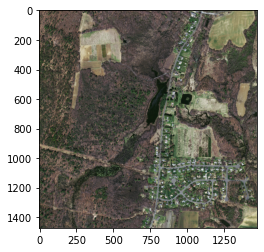

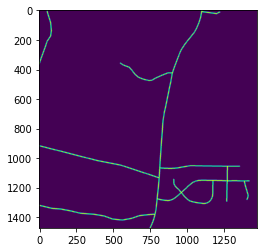

In [ ]:
#try reading images:

test_generator = DataGeneratorFolder(root_dir = './road_segmentation/training',#'./data/road_segmentation_ideal/training',
                                     image_folders = ['input/'], 
                                     mask_folders = ['output/'],
                                     batch_size = 1,
                                     nb_y_features = 1, 
                                     #augmentation = aug_with_crop
                                     )
Xtest, ytest = test_generator.__getitem__(0)
plt.imshow(Xtest[0])     
plt.show()
plt.imshow(ytest[0, :,:,0])
plt.show() 

In [ ]:
IMAGE_FOLDER = './osm_data/images_256x256/images'
image_filenames = sorted(os.listdir(IMAGE_FOLDER))
X = range(0,len(image_filenames))
cv_outer = KFold(n_splits=NUMBER_OF_FOLDS, shuffle=True, random_state=1)
test_indexes_per_fold = {}
train_indexes_per_fold = {}
fold_number = 0


for train_ix, test_ix in cv_outer.split(X):
  fold_number = fold_number + 1

  train_indexes = []
  for train_index in train_ix:
    train_indexes.append(train_index)
  train_indexes_per_fold[fold_number] = train_indexes

  test_indexes = []
  for test_index in test_ix:
    test_indexes.append(test_index)
  test_indexes_per_fold[fold_number] = test_indexes



## Callbacks

In [ ]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard

# reduces learning rate on plateau
lr_reducer = ReduceLROnPlateau(factor=0.1,
                               cooldown= 10,
                               patience=10,verbose =1,
                               min_lr=0.1e-5)
mode_autosave = ModelCheckpoint("./weights/road_crop.efficientnetb0imgsize.h5",monitor='val_iou_score', 
                                   mode = 'max', save_best_only=True, verbose=1, period =10)

# stop learining as metric on validatopn stop increasing
early_stopping = EarlyStopping(patience=10, verbose=1, mode = 'auto') 

# tensorboard for monitoring logs
tensorboard = TensorBoard(log_dir='./logs/tenboard', histogram_freq=0,
                          write_graph=True, write_images=False)

callbacks = [mode_autosave, lr_reducer, tensorboard, early_stopping]

In [ ]:
def plot_training_history(history):
    """
    Plots model training history 
    """
    epoch = range(len(history["loss"]))
    fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
    ax_loss.plot(epoch, history["loss"], label="Train loss")
    ax_loss.plot(epoch, history["val_loss"], label="Validation loss")
    ax_loss.legend()
    ax_acc.plot(epoch, history["iou_score"], label="Train iou")
    ax_acc.plot(epoch, history["val_iou_score"], label="Validation iou")
    ax_acc.legend()
    

In [ ]:
madagascar_image_folder = 'osm_data/images_256x256/images'
madagascar_mask_folder = 'osm_data/masks_256x256/masks'


massachussettes_train_folder_images = "road_segmentation/training/input"
massachussettes_validation_folder_images = "road_segmentation/testing/input"
massachussettes_train_folder_masks = "road_segmentation/training/output"
massachussettes_validation_folder_masks = "road_segmentation/testing/output"

In [ ]:
batch_size = 4
for current_fold_number in range(STARTING_FOLD, NUMBER_OF_FOLDS+1):
  print(f"current fold: {current_fold_number}")

  k = len(train_indexes_per_fold[current_fold_number])*0.8

  random.seed(1)
  train_indexes_for_loss = sorted(random.sample(train_indexes_per_fold[current_fold_number], int(k)))
  validation_indexes = sorted(list(set(train_indexes_per_fold[current_fold_number]).difference(train_indexes_for_loss)))

  images_without_test_images_for_training = pd.Series(list(massachussettes_train_folder_images + "/" + pd.Series(os.listdir(massachussettes_train_folder_images))) + list(
      madagascar_image_folder + "/" + pd.Series(image_filenames).iloc[train_indexes_for_loss]

  )) # from.. massachussets.. all in the training folder

  images_without_test_images_for_validation = pd.Series(list(massachussettes_validation_folder_images + "/" + pd.Series(os.listdir(massachussettes_validation_folder_images))) + list(
      madagascar_image_folder + "/" + pd.Series(image_filenames).iloc[validation_indexes]

  )) # from.. massachussets.. all in the validation folder


  masks_without_test_images_for_training = pd.Series(list(massachussettes_train_folder_masks + "/" + pd.Series(os.listdir(massachussettes_train_folder_masks))) + list(
      madagascar_mask_folder + "/" + pd.Series(image_filenames).iloc[train_indexes_for_loss]

  )) # from.. massachussets.. all in the training folder

  masks_without_test_images_for_validation = pd.Series(list(massachussettes_validation_folder_masks + "/" + pd.Series(os.listdir(massachussettes_validation_folder_masks))) + list(
      madagascar_mask_folder + "/" + pd.Series(image_filenames).iloc[validation_indexes]

  )) # from.. massachussets.. all in the validation folder


  train_generator = DataGeneratorFolder(root_dir = './',#'./data/road_segmentation_ideal/training',
                                      image_folders = [madagascar_image_folder, massachussettes_train_folder_images],
                                      #mask_folder = 'masks_256x256/masks',
                                    mask_folders = [madagascar_mask_folder, massachussettes_train_folder_masks],
                                    augmentation = aug_with_crop,
                                      batch_size = batch_size,
                                      nb_y_features = 1, 
                                        image_size=IMAGE_SIZE[0],
                                      #augmentation = aug_with_crop
                                        image_names = images_without_test_images_for_training,#images_without_test_images_for_training,
                                        mask_names = masks_without_test_images_for_training,
                                        fold_number = current_fold_number
                                      )

  test_generator  = DataGeneratorFolder(root_dir = './',#'./data/road_segmentation_ideal/training',
                                      image_folders = [madagascar_image_folder, massachussettes_validation_folder_images ],
                                      #mask_folder = 'masks_256x256/masks',
                                    mask_folders =  [madagascar_mask_folder, massachussettes_validation_folder_masks ],
                                      batch_size = 1,
                                      nb_y_features = 1, 
                                        image_names = images_without_test_images_for_validation,#images_without_test_images_for_validation,
                                        mask_names = masks_without_test_images_for_validation,
                                        fold_number = current_fold_number
                                      #augmentation = aug_with_crop
                                      )
  model = Unet(backbone_name = 'efficientnetb0', encoder_weights='imagenet', encoder_freeze = False)
  model.compile(optimizer = Adam(),
                  loss=bce_jaccard_loss, metrics=[iou_score])

  history = model.fit_generator(train_generator, shuffle =True,
                    epochs=NUMBER_OF_EPOCHS, workers=30, use_multiprocessing=True,
                    validation_data = test_generator, 
                    verbose = 1, callbacks=callbacks)  
  plot_training_history(history.history)
  model.save(f"cached_intermediate_data/model_massachussettes_madagascar_fold{current_fold_number}.h5")
  with open(f'cached_intermediate_data/history_massachussettes_madagascar_fold{current_fold_number}.pickle', 'wb') as file_pi:
      pickle.dump(history.history, file_pi)

    


In [ ]:
history = pickle.load(open(f'cached_intermediate_data/history_madagascar_fold{current_fold_number}.pickle', "rb"))
plot_training_history(history)
